In [ ]:
file_path = "/mnt/scratch/yuankeji/ibex-zonation/try2/"

In [ ]:
def process_channel2(image_channel, channel_name, p1 = 1, p99 = 1):
    image_test = np.clip(image_channel, 0, 65000)
    _, image_test = cv2.threshold(image_test, p1, 255, cv2.THRESH_BINARY)

    
    if 'p1' in locals() and 'p99' in locals():
        print("----------------------------------check--------------------------------")
        image_channel = np.clip(image_channel, p1, p99)
        image_channel = ((image_channel - p1) / (p99 - p1) * 255).astype(np.uint8)
    
    binary_image = image_test

    plt.imshow(binary_image, cmap='gray')
    plt.title(f"Binary Image {channel_name} Channel)")
    plt.axis('off')
    
    save_path = f'/mnt/scratch/yuankeji/ibex-zonation/try2/{channel_name}.png'  # dynamic path using f-string
    plt.savefig(save_path)
    plt.close()

    return binary_image

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries
from skimage.color import label2rgb
from pathlib import Path
import nrrd
from scipy.signal import find_peaks, savgol_filter
from sklearn.mixture import GaussianMixture
from scipy.ndimage import gaussian_filter1d

def read_nrrd(image_path: Path) -> np.ndarray:
    """Read the image data from an NRRD file."""
    data, header = nrrd.read(str(image_path))
    print("NRRD Header:", header)
    print("Image Shape:", data.shape)
    return data

def process_channel(image_channel, channel_name):
    if channel_name == "Green":
        p1 = 3201
        p99 = 9826
    elif channel_name == "Blue":
        p1 = 4042
        p99 = 20727
    elif channel_name == "Red":
        p1 = 678
        p99 = 1649
    else:
        p1 = 1
        
    image_test = np.clip(image_channel, 0, 65000)
    _, image_test = cv2.threshold(image_test, p1, 255, cv2.THRESH_BINARY)

    
    if 'p1' in locals() and 'p99' in locals():
        print("----------------------------------check--------------------------------")
        image_channel = np.clip(image_channel, p1, p99)
        image_channel = ((image_channel - p1) / (p99 - p1) * 255).astype(np.uint8)
    
    binary_image = image_test

    plt.imshow(binary_image, cmap='gray')
    plt.title(f"Binary Image ({channel_name} Channel)")
    plt.axis('off')
    
    save_path = f'{file_path}{channel_name}.png'  # dynamic path using f-string
    plt.savefig(save_path)
    plt.close()

    return binary_image


def reduce_resolution(image, scale_factor):
    """
    Reduce the resolution of a 2D or 3D image by the given scale factor.
    
    Args:
        image (np.ndarray): The input image (e.g., shape (height, width) or (height, width, channels)).
        scale_factor (int): The factor by which to reduce the resolution.

    Returns:
        np.ndarray: The downsampled image or original image if scale is invalid.
    """
    # Check if the image is 2D or 3D
    if image.ndim == 2:
        height, width = image.shape
        channels = 1
    elif image.ndim == 3:
        height, width, channels = image.shape
    else:
        raise ValueError(f"Unsupported image dimensions: {image.shape}")

    # Validate scale factor
    if scale_factor >= min(height, width):
        print(f"Scale factor {scale_factor} is too large for image size {height}x{width}. Returning original image.")
        return image  # Return the original image if the scale factor is too large

    new_height, new_width = height // scale_factor, width // scale_factor

    # Resize the image
    if channels == 1:  # Single channel (2D image)
        resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
    else:  # Multi-channel (3D image)
        resized_channels = [
            cv2.resize(image[:, :, channel], (new_width, new_height), interpolation=cv2.INTER_AREA)
            for channel in range(channels)
        ]
        resized_image = np.stack(resized_channels, axis=-1)

    return resized_image

In [4]:
import cv2
import matplotlib.pyplot as plt

folder_path = Path('../../nrrd/PORTAL_CENTRAL_FULL_SECTION_20250131.nrrd')
output_path = "foreground_mask.tif"

image = read_nrrd(folder_path)

image1 = process_channel(image[:, :, 1], "Red")
image2 = process_channel(image[:, :, 2], "Green")
image3 = process_channel(image[:, :, 0], "Blue")


NRRD Header: OrderedDict({'type': 'uint16', 'encoding': 'raw', 'endian': 'big', 'dimension': 3, 'sizes': array([31314, 22177,     3]), 'space dimension': 3, 'space directions': array([[0.321866  , 0.        , 0.        ],
       [0.        , 0.32186594, 0.        ],
       [0.        , 0.        , 1.        ]]), 'space units': ['microns', 'microns', 'microns']})
Image Shape: (31314, 22177, 3)
----------------------------------check--------------------------------
----------------------------------check--------------------------------
----------------------------------check--------------------------------


uint16


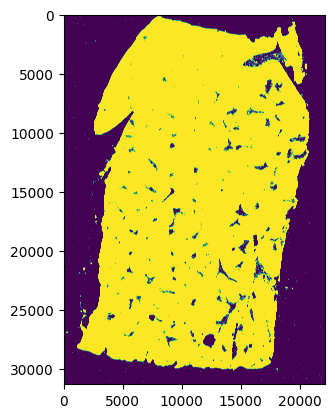

In [5]:
print(image1.dtype)
if image1.dtype != np.uint8:
    image11 = image1.astype(np.uint8) 

# Ensure it's grayscale
if len(image11.shape) == 3:  # If it's a color image
    image11 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

plt.imshow(image11)

True

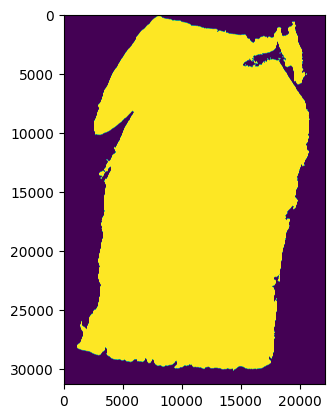

In [6]:
# 找到所有轮廓
contours, hierarchy = cv2.findContours(image11, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 找到最大轮廓
largest_contour = max(contours, key=cv2.contourArea)

# 创建一个与原图大小相同的全黑 mask
mask = np.zeros_like(image11)

cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
plt.imshow(mask)
cv2.imwrite(str(file_path + "largest_contour_mask.png"), mask)


In [26]:
print(mask.shape)

(31314, 22177)


In [7]:
image1 = process_channel2(image[:, :, 1], "red", 2934, 7558)

----------------------------------check--------------------------------


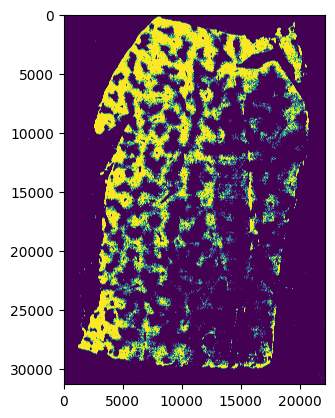

In [8]:
plt.imshow(image1)

(31314, 22177)
(31314, 22177)
(31314, 22177)
(31314, 22177)


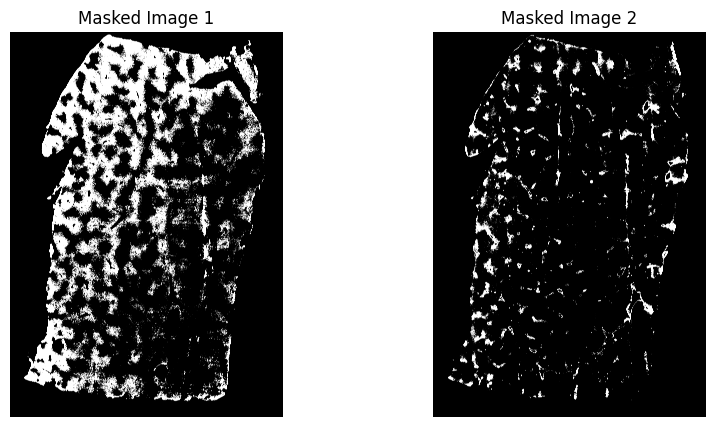

In [9]:
print(image1.shape[:2])
print(image2.shape[:2])
print(image11.shape[:2])
print(mask.shape)

# Apply mask using bitwise_and
masked_image1 = cv2.bitwise_and(image1, image1, mask=mask)
masked_image2 = cv2.bitwise_and(image2, image2, mask=mask)

# Convert from BGR to RGB for correct color representation
masked_image1_rgb = cv2.cvtColor(masked_image1, cv2.COLOR_BGR2RGB)
masked_image2_rgb = cv2.cvtColor(masked_image2, cv2.COLOR_BGR2RGB)

if masked_image1_rgb.dtype != np.uint8:
    masked_image1_rgb = (masked_image1_rgb / masked_image1_rgb.max() * 255).astype(np.uint8)

if masked_image2_rgb.dtype != np.uint8:
    masked_image2_rgb = (masked_image2_rgb / masked_image2_rgb.max() * 255).astype(np.uint8)

# Show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(masked_image1_rgb)
plt.title("Masked Image 1")
plt.axis("off")  # Hide axis

plt.subplot(1, 2, 2)
plt.imshow(masked_image2_rgb)
plt.title("Masked Image 2")
plt.axis("off")

plt.show()

plt.imsave(file_path + "masked_image1.png", masked_image1_rgb)
plt.imsave(file_path + "masked_image2.png", masked_image2_rgb)


In [10]:
print(masked_image1_rgb.shape)

(31314, 22177, 3)


In [10]:
masked_image1_rgb_resized = cv2.resize(masked_image1_rgb, (masked_image1.shape[1], masked_image1.shape[0]))
masked_image2_rgb_resized = cv2.resize(masked_image2_rgb, (masked_image2.shape[1], masked_image2.shape[0]))

masked_image1_rgb_gray = cv2.cvtColor(masked_image1_rgb_resized, cv2.COLOR_BGR2GRAY)
masked_image2_rgb_gray = cv2.cvtColor(masked_image2_rgb_resized, cv2.COLOR_BGR2GRAY)
print(masked_image1_rgb_gray.shape)
print(masked_image1_rgb_gray.dtype)
print(masked_image2_rgb_gray.shape)
print(masked_image2_rgb_gray.dtype)

(31314, 22177)
uint8
(31314, 22177)
uint8


In [11]:
def get_filtered_contours(image, channel_name):
    contours, hierarchy = cv2.findContours(image.reshape(image.shape[0], image.shape[1], 1).astype(np.uint8), cv2.RETR_TREE,
                                       cv2.CHAIN_APPROX_SIMPLE)

    print(f"Total contours found: {len(contours)}")


    contours2 = sorted(contours, key=cv2.contourArea, reverse=True)
    tissue_boundary = contours2.pop(0)

    filtered_contours = []
    areas = []
    
    temp_filtered = []
    for rank, contour in enumerate(contours2):
        area = cv2.contourArea(contour)
        if area >= 60000:  
            temp_filtered.append(contour)
    
    # Iterate through the contours
    if hierarchy is not None:
        hierarchy = hierarchy[0]  # Get the first (and only) level of the hierarchy
        for rank, contour in enumerate(temp_filtered):
            if hierarchy[0][2] == -1:  # Check if the first child is -1
                filtered_contours.append(contour)

    print("-----------------------------")
    print(f"Contours after filtering: {len(filtered_contours)}")
    print(f"Number of contours filtered out: {len(contours) - len(filtered_contours)}")
    print("-----------------------------")

    filtered_contours_image = np.zeros_like(image, dtype=np.uint8)
    cv2.drawContours(filtered_contours_image, filtered_contours, -1, 255, thickness=16)  # Draw other contours
    cv2.imwrite(file_path + f"{channel_name}_filtered_contours.png", filtered_contours_image) 

(31314, 22177)
(31314, 22177)


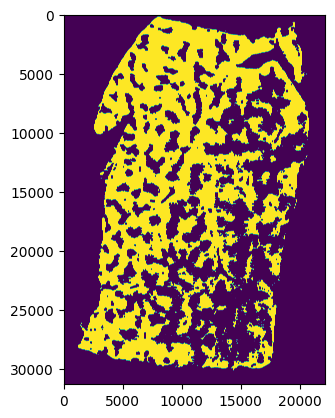

In [12]:
kernel = np.ones((3,3), np.uint8)

# blurred_image = cv2.GaussianBlur(cropped_image1_gray, (101,101), 0)
image_binary11 = cv2.morphologyEx(masked_image1_rgb_gray, cv2.MORPH_CLOSE, kernel, iterations=50)  


print(masked_image1_rgb_gray.shape)
print(image_binary11.shape)
plt.imshow(image_binary11)
plt.imsave(file_path+"image_binary11.png", image_binary11)

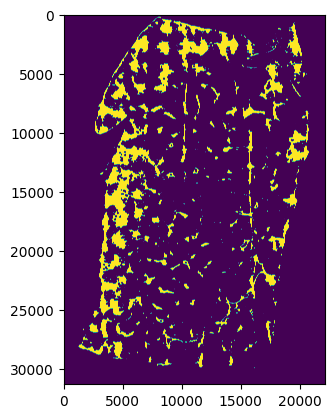

In [14]:
image_binary22 = cv2.morphologyEx(masked_image2_rgb_gray, cv2.MORPH_CLOSE, kernel, iterations=50)
plt.imshow(image_binary22)
plt.imsave(file_path+"image_binary22.png", image_binary22)

In [14]:
get_filtered_contours(image_binary11, "Red")
get_filtered_contours(image_binary22, "Green")

Total contours found: 1307
-----------------------------
Contours after filtering: 120
Number of contours filtered out: 1187
-----------------------------
Total contours found: 1914
-----------------------------
Contours after filtering: 128
Number of contours filtered out: 1786
-----------------------------


Red contours found: 111
Green contours found: 124
Contour 0: Partial overlap - kept only overlapping portion
Contour 1: No overlap - kept entire contour
Contour 2: Partial overlap - kept only overlapping portion
Contour 3: Partial overlap - kept only overlapping portion
Contour 4: No overlap - kept entire contour
Contour 5: No overlap - kept entire contour
Contour 6: No overlap - kept entire contour
Contour 7: Partial overlap - kept only overlapping portion
Contour 8: Partial overlap - kept only overlapping portion
Contour 9: Partial overlap - kept only overlapping portion
Contour 10: Partial overlap - kept only overlapping portion
Contour 11: No overlap - kept entire contour
Contour 12: No overlap - kept entire contour
Contour 13: No overlap - kept entire contour
Contour 14: No overlap - kept entire contour
Contour 15: No overlap - kept entire contour
Contour 16: Partial overlap - kept only overlapping portion
Contour 17: Partial overlap - kept only overlapping portion
Contour 18: Par

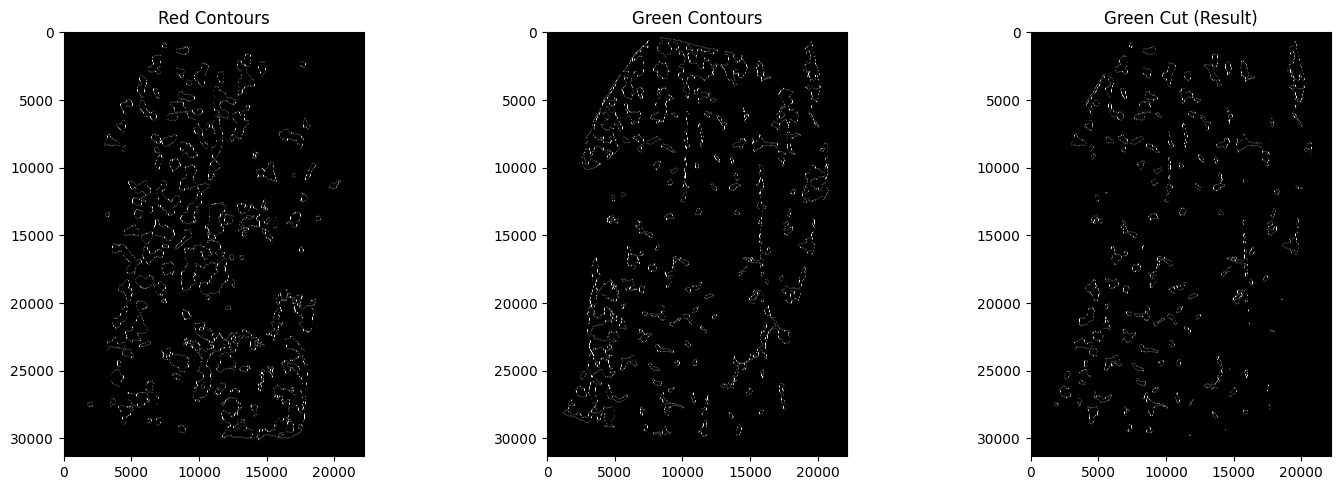

In [15]:
import cv2
import numpy as np

red_contours_img = cv2.imread(file_path + "Red_filtered_contours.png", cv2.IMREAD_GRAYSCALE)
green_contours_img = cv2.imread(file_path + "Green_filtered_contours.png", cv2.IMREAD_GRAYSCALE)

# Find contours in the red and green images
red_contours, _ = cv2.findContours(red_contours_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
green_contours, _ = cv2.findContours(green_contours_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"Red contours found: {len(red_contours)}")
print(f"Green contours found: {len(green_contours)}")

# Create a mask for the red contours (filled to check for overlap)
red_mask = np.zeros_like(red_contours_img)
cv2.drawContours(red_mask, red_contours, -1, 255, thickness=cv2.FILLED)

# Create our output image (initially all black)
green_cut = np.zeros_like(green_contours_img)

# Process each green contour
for i, contour in enumerate(green_contours):
    # Create a mask for this individual green contour
    contour_mask = np.zeros_like(green_contours_img)
    cv2.drawContours(contour_mask, [contour], -1, 255, thickness=cv2.FILLED)
    
    # Check overlap with red mask
    overlap = cv2.bitwise_and(contour_mask, red_mask)
    overlap_area = np.count_nonzero(overlap)
    contour_area = np.count_nonzero(contour_mask)
    
    if overlap_area > 0:
        # Case: There is some overlap
        if overlap_area == contour_area:
            # Case: Complete overlap - keep the entire contour
            cv2.drawContours(green_cut, [contour], -1, 255, thickness=16)
            print(f"Contour {i}: Complete overlap - kept entire contour")
        else:
            # Case: Partial overlap - find the overlapping contour and draw it
            overlap_contours, _ = cv2.findContours(overlap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(green_cut, overlap_contours, -1, 255, thickness=16)
            print(f"Contour {i}: Partial overlap - kept only overlapping portion")
    else:
        # Case: No overlap - keep the entire contour
        cv2.drawContours(green_cut, [contour], -1, 255, thickness=16)
        print(f"Contour {i}: No overlap - kept entire contour")

# Save the processed image
cv2.imwrite(file_path + "green_cut.png", green_cut)
print("Processed image saved as 'green_cut.png'")

# Optional: Display the images for verification
if True:  # Set to True to display images
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(red_contours_img, cmap='gray')
    plt.title('Red Contours')
    
    plt.subplot(132)
    plt.imshow(green_contours_img, cmap='gray')
    plt.title('Green Contours')
    
    plt.subplot(133)
    plt.imshow(green_cut, cmap='gray')
    plt.title('Green Cut (Result)')
    
    plt.tight_layout()
    plt.show()

In [16]:
def overlap():
    red_contours = cv2.imread(file_path + "Red_filtered_contours.png", cv2.IMREAD_GRAYSCALE)
    green_contours = cv2.imread(file_path + "green_cut.png", cv2.IMREAD_GRAYSCALE)

    # Create a simple overlap image (binary)
    overlap = np.zeros_like(red_contours, dtype=np.uint8)
    overlap[np.logical_or(red_contours > 0, green_contours > 0)] = 255

    # Save the simple overlap image
    cv2.imwrite(file_path + "overlap.png", overlap)

    # Create a colored overlap image
    # Create an empty RGB image
    colored_overlap = np.zeros((red_contours.shape[0], red_contours.shape[1], 3), dtype=np.uint8)

    # Color the contours
    # Red contours (B=0, G=0, R=255)
    colored_overlap[red_contours > 0] = [0, 0, 255]  # BGR format for OpenCV

    # Green contours (B=0, G=255, R=0)
    colored_overlap[green_contours > 0] = [0, 255, 0]  # BGR format for OpenCV

    # Handle overlapping areas (optional) - make them yellow
    overlapping_areas = np.logical_and(red_contours > 0, green_contours > 0)
    colored_overlap[overlapping_areas] = [0, 255, 255]  # Yellow in BGR

    # Save the colored overlap image
    cv2.imwrite(file_path + "check_overlap.png", colored_overlap)

    print("Images successfully overlapped and saved.")

In [17]:
overlap()

Images successfully overlapped and saved.


In [ ]:
import cv2
import numpy as np

def remove_red_contours_with_green_contact():
    overlap_img = cv2.imread(file_path + "check_overlap.png")
    
    if overlap_img is None:
        print("Error: Could not load the overlap image")
        return
    
    red_areas_mask = np.zeros_like(overlap_img[:,:,0])
    red_areas_mask[overlap_img[:,:,2] > 0] = 255  # B=0, G=0/255, R>0
    
    green_areas_mask = np.zeros_like(overlap_img[:,:,0])
    green_areas_mask[overlap_img[:,:,1] > 0] = 255  # B=0, G>0, R=0/255
    
    red_contours, _ = cv2.findContours(red_areas_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    print(f"发现 {len(red_contours)} 个红色区域轮廓")
    
    result_mask = np.zeros_like(red_areas_mask)
    
    red_contours_to_keep = []
    red_contours_to_remove = []
    
    for i, contour in enumerate(red_contours):
        contour_mask = np.zeros_like(red_areas_mask)
        cv2.drawContours(contour_mask, [contour], -1, 255, thickness=cv2.FILLED)
        
        red_part = np.logical_and(contour_mask > 0, overlap_img[:,:,2] > 0)
        
        has_green = False
        
        y_indices, x_indices = np.where(contour_mask > 0)
        for j in range(len(y_indices)):
            y, x = y_indices[j], x_indices[j]
            if overlap_img[y, x, 1] > 0:
                has_green = True
                break
        
        if has_green:
            red_contours_to_remove.append(contour)
            print(f"删除红色轮廓 {i}，因为它与绿色区域有接触")
        else:
            red_contours_to_keep.append(contour)
            cv2.drawContours(result_mask, [contour], -1, 255, thickness=cv2.FILLED)
            print(f"保留红色轮廓 {i}，没有与绿色区域接触")
    
    final_image = np.zeros_like(overlap_img)
    
    pure_green_mask = np.zeros_like(overlap_img[:,:,0])
    pure_green_mask[(overlap_img[:,:,1] > 0) & (overlap_img[:,:,2] == 0)] = 255
    
    final_image[result_mask > 0] = [0, 0, 255]  
    
    final_image[green_areas_mask > 0] = [0, 255, 0]  
    
    yellow_mask = np.zeros_like(overlap_img[:,:,0])
    yellow_mask[(overlap_img[:,:,1] > 0) & (overlap_img[:,:,2] > 0)] = 255
    final_image[yellow_mask > 0] = [0, 255, 255]  
    
    cv2.imwrite(file_path + "filtered_overlap.png", final_image)
    
    contour_image = np.zeros_like(overlap_img)
    
    cv2.drawContours(contour_image, red_contours_to_keep, -1, [0, 0, 255], thickness=16)
    
    green_contours, _ = cv2.findContours(green_areas_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(contour_image, green_contours, -1, [0, 255, 0], thickness=16)
    
    cv2.imwrite(file_path + "filtered_contours.png", contour_image)
    
    print(f"处理完成。共发现 {len(red_contours)} 个红色区域轮廓。")
    print(f"保留了 {len(red_contours_to_keep)} 个红色轮廓，移除了 {len(red_contours_to_remove)} 个红色轮廓。")
    print(f"结果已保存为 'filtered_overlap.png' 和 'filtered_contours.png'")

# 调用函数
remove_red_contours_with_green_contact()

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def create_vessel_masks(contour_path, output_path):
    """
    Create central and portal vessel masks from a colored contour image.
    Assumes green contours are central vessels and red contours are portal vessels.
    
    Parameters:
    - contour_path: Path to the contour image
    - output_path: Path to save the resulting masks
    
    Returns:
    - Dictionary with paths to the created masks
    """
    # Read the contour image
    contours_img = cv2.imread(contour_path)
    
    if contours_img is None:
        raise ValueError(f"Could not read image from {contour_path}")
    
    # Create empty masks
    height, width = contours_img.shape[:2]
    central_mask = np.zeros((height, width), dtype=np.uint8)
    portal_mask = np.zeros((height, width), dtype=np.uint8)
    lobule_mask = np.zeros((height, width), dtype=np.uint8)
    
    # Split into color channels
    b, g, r = cv2.split(contours_img)
    
    # Extract red contours (portal vessels)
    red_threshold = 100
    red_mask = (r > red_threshold) & (g < red_threshold) & (b < red_threshold)
    portal_mask[red_mask] = 255
    
    # Extract green contours (central vessels)
    green_threshold = 100
    green_mask = (g > green_threshold) & (r < green_threshold) & (b < green_threshold)
    central_mask[green_mask] = 255
    
    # Create a combined mask (all vessels/boundaries)
    lobule_mask[(red_mask) | (green_mask)] = 255
    
    # Find contours to fill them (create solid masks)
    central_contours, _ = cv2.findContours(central_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    portal_contours, _ = cv2.findContours(portal_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create filled masks
    central_filled = np.zeros_like(central_mask)
    cv2.drawContours(central_filled, central_contours, -1, 255, thickness=cv2.FILLED)
    
    portal_filled = np.zeros_like(portal_mask)
    cv2.drawContours(portal_filled, portal_contours, -1, 255, thickness=cv2.FILLED)
    
    # Save masks
    central_path = os.path.join(output_path, "central_vessels.png")
    portal_path = os.path.join(output_path, "portal_vessels.png")
    lobule_path = os.path.join(output_path, "lobule_boundary.png")
    central_filled_path = os.path.join(output_path, "central_vessels_filled.png")
    portal_filled_path = os.path.join(output_path, "portal_vessels_filled.png")
    
    cv2.imwrite(central_path, central_mask)
    cv2.imwrite(portal_path, portal_mask)
    cv2.imwrite(lobule_path, lobule_mask)
    cv2.imwrite(central_filled_path, central_filled)
    cv2.imwrite(portal_filled_path, portal_filled)
    
    print(f"Vessel masks created and saved to {output_path}")
    
    return {
        "central": central_filled_path,
        "portal": portal_filled_path,
        "lobule": lobule_path
    }

In [35]:
def calculate_portality_map(central_path, portal_path, lobule_path, output_path):
    """
    Calculate portality map from vessel masks.
    
    Parameters:
    - central_path: Path to central vessel mask
    - portal_path: Path to portal vessel mask
    - lobule_path: Path to lobule boundary mask
    - output_path: Path to save the resulting portality map
    
    Returns:
    - Portality map as a numpy array
    """
    # Load masks
    central_mask = cv2.imread(central_path, cv2.IMREAD_GRAYSCALE)
    portal_mask = cv2.imread(portal_path, cv2.IMREAD_GRAYSCALE)
    lobule_mask = cv2.imread(lobule_path, cv2.IMREAD_GRAYSCALE)

    # Create pericentral boundary mask
    # Pixels are false if they are in central vessels
    pericentral_mask = np.ones_like(central_mask, dtype=np.uint8) * 255
    pericentral_mask[central_mask > 0] = 0
    pericentral_mask[mask == 0] = 0
    # Create portal boundary mask
    # Pixels are false if they are outside lobule boundary or in portal vessels
    portal_boundary_mask = np.ones_like(portal_mask, dtype=np.uint8) * 255
    portal_boundary_mask[portal_mask > 0] = 0   
    portal_boundary_mask[mask == 0] = 0

    # Calculate distance transforms
    # cv2.distanceTransform calculates distance to nearest zero pixel
    dist_central = cv2.distanceTransform(pericentral_mask, cv2.DIST_L2, 3)
    dist_portal = cv2.distanceTransform(portal_boundary_mask, cv2.DIST_L2, 3)

    max_dist_central = np.max(dist_central)
    max_dist_portal = np.max(dist_portal)
    
    # Print statistics for debugging
    print(f"Central distance range: {np.min(dist_central)} to {np.max(dist_central)}")
    print(f"Portal distance range: {np.min(dist_portal)} to {np.max(dist_portal)}")
    
    # Calculate portality
    # p(x,y) = 1 - dc(x,y) / (dc(x,y) + dp(x,y))
    # Avoid division by zero
    denominator = dist_central + dist_portal
    denominator[denominator == 0] = 1e-10  # Small value to avoid division by zero
    
    portality = 1.0 - (dist_central / denominator)
    visualize_portality = (portality * 255).astype(np.uint8)
    plt.imshow(visualize_portality)
    portality_path = os.path.join(output_path, "visualize_portality.png")
    cv2.imwrite(portality_path, visualize_portality)
    print(f'denominator: {denominator}')
    print(f"Portality distance range: {np.min(portality)} to {np.max(portality)}")

In [20]:
contour_path = os.path.join(file_path, "filtered_contours.png")

# Step 1: Create vessel masks
mask_paths = create_vessel_masks(contour_path, file_path)

Vessel masks created and saved to /mnt/scratch/yuankeji/ibex-zonation/try2/


In [40]:
# Step 2: Calculate portality map
portality_map = calculate_portality_map(
    mask_paths["central"], 
    mask_paths["portal"], 
    mask_paths["lobule"], 
    file_path
)

Central distance range: 0.0 to 2401.37255859375
Portal distance range: 0.0 to 3130.049072265625
Portality distance range: 0.0 to 1.0


In [39]:
def calculate_portality_map(central_path, portal_path, lobule_path, output_path):
    """
    Calculate portality map from vessel masks.
    
    Parameters:
    - central_path: Path to central vessel mask
    - portal_path: Path to portal vessel mask
    - lobule_path: Path to lobule boundary mask
    - mask: Tissue boundary mask as numpy array
    - output_path: Path to save the resulting portality map
    
    Returns:
    - Portality map as a numpy array
    """
    # Load masks
    central_mask = cv2.imread(central_path, cv2.IMREAD_GRAYSCALE)
    portal_mask = cv2.imread(portal_path, cv2.IMREAD_GRAYSCALE)
    lobule_mask = cv2.imread(lobule_path, cv2.IMREAD_GRAYSCALE)
    
    # First, restrict all calculations to the tissue area
    # Create pericentral boundary mask within tissue only
    pericentral_mask = np.zeros_like(central_mask, dtype=np.uint8)
    pericentral_mask[(mask > 0) & (central_mask == 0)] = 255  # Only set pixels INSIDE tissue and NOT in central vessels to 255
    
    # Create portal boundary mask within tissue only
    portal_boundary_mask = np.zeros_like(portal_mask, dtype=np.uint8)
    portal_boundary_mask[(mask > 0) & (portal_mask == 0)] = 255  # Only set pixels INSIDE tissue and NOT in portal vessels to 255
    
    # Save intermediate masks for debugging
    cv2.imwrite(os.path.join(output_path, "pericentral_mask_debug.png"), pericentral_mask)
    cv2.imwrite(os.path.join(output_path, "portal_boundary_mask_debug.png"), portal_boundary_mask)
    
    # Calculate distance transforms - only within the tissue mask
    dist_central = cv2.distanceTransform(pericentral_mask, cv2.DIST_L2, 3)
    dist_portal = cv2.distanceTransform(portal_boundary_mask, cv2.DIST_L2, 3)
    
    # Anything outside tissue mask should have zero distance
    dist_central[mask == 0] = 0
    dist_portal[mask == 0] = 0
    
    max_dist_central = np.max(dist_central)
    max_dist_portal = np.max(dist_portal)
    
    # Print statistics for debugging
    print(f"Central distance range: {np.min(dist_central)} to {np.max(dist_central)}")
    print(f"Portal distance range: {np.min(dist_portal)} to {np.max(dist_portal)}")
    
    # Create distance visualizations for debugging
    dist_central_viz = np.zeros_like(dist_central, dtype=np.uint8)
    dist_portal_viz = np.zeros_like(dist_portal, dtype=np.uint8)
    
    if max_dist_central > 0:
        dist_central_viz = ((dist_central / max_dist_central) * 255).astype(np.uint8)
    if max_dist_portal > 0:
        dist_portal_viz = ((dist_portal / max_dist_portal) * 255).astype(np.uint8)
    
    cv2.imwrite(os.path.join(output_path, "dist_central_debug.png"), dist_central_viz)
    cv2.imwrite(os.path.join(output_path, "dist_portal_debug.png"), dist_portal_viz)
    
    # Calculate portality only for valid tissue pixels
    # Set a tissue mask for calculation
    valid_pixels = mask > 0
    
    # Initialize portality with zeros
    portality = np.zeros_like(dist_central, dtype=float)
    
    # Calculate portality only for valid tissue pixels
    denominator = dist_central + dist_portal
    # Avoid division by zero only for pixels we care about
    denominator[(denominator == 0) & valid_pixels] = 1e-10
    
    # Calculate portality only for tissue pixels
    portality[valid_pixels] = 1.0 - (dist_central[valid_pixels] / denominator[valid_pixels])
    
    # Visualize the portality
    visualize_portality = (portality * 255).astype(np.uint8)
    portality_path = os.path.join(output_path, "visualize_portality.png")
    cv2.imwrite(portality_path, visualize_portality)
    
    print(f"Portality distance range: {np.min(portality[valid_pixels])} to {np.max(portality[valid_pixels])}")
    
    return portality